<a href="https://colab.research.google.com/github/jaisakthism/Few-Shot-Semantic-Segmentation-Papers/blob/master/FLOOD_IMAGE_CLASSIFIER_ef3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading required libraries and functions
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [ ]:
import tensorflow as tf
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import PIL.Image
import cv2
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import random
from keras import backend as K
import os
from keras.layers import *
import re
import zipfile
import pathlib
import PIL
import pandas as pd

In [ ]:
from PIL import Image, ImageOps
filelist_trainx = sorted(glob.glob("/content/drive/MyDrive/social_media_images/devset_images_zipfile/devset_images/*/*"))
X_train = np.array([np.array(PIL.Image.open(fname).resize((300,300),PIL.Image.ANTIALIAS)) for fname in filelist_trainx])
X_train.shape

(5280, 300, 300, 3)

In [ ]:
X_train.shape

(5280, 300, 300, 3)

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train  = pd.read_csv("/content/drive/MyDrive/social_media_images/devset_images_zipfile/devset_images_gt.csv", header = None)
Y_train = Y_train.iloc[:,1].values
Y_train = to_categorical(Y_train)
Y_train = Y_train.astype('float32')
#Y_train.index = Y_train.index + 1
#tf.convert_to_tensor(Y_train)
Y_train = np.array(Y_train)
print(Y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.33, random_state = 54)

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
img_height = 300
img_width = 300

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width,3))
    x = img_augmentation(inputs)
    model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    mse = tf.keras.losses.MeanSquaredLogarithmicError()
    cc = "categorical_crossentropy"
    sce = tf.keras.losses.MeanSquaredError()
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    model.compile(
        optimizer= optimizer, loss= mse, metrics=["accuracy"]
    )
    return model


In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
NUM_CLASSES = 2
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 20 #@param {type:"slider", min:8, max:100, step:1}
#hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
hist = model.fit(x_train,y_train,
                  epochs= epochs,
                  #nitial_epoch=hist.epoch[-1],
                  validation_data=(x_val, y_val))

Epoch 1/20
111/111 [==============================] - 40s 268ms/step - loss: 0.1362 - accuracy: 0.5884 - val_loss: 0.1196 - val_accuracy: 0.6420
Epoch 2/20
111/111 [==============================] - 26s 239ms/step - loss: 0.1293 - accuracy: 0.6090 - val_loss: 0.1216 - val_accuracy: 0.6334
Epoch 3/20
111/111 [==============================] - 27s 240ms/step - loss: 0.1263 - accuracy: 0.6087 - val_loss: 0.1267 - val_accuracy: 0.6363
Epoch 4/20
111/111 [==============================] - 27s 241ms/step - loss: 0.1243 - accuracy: 0.6132 - val_loss: 0.1249 - val_accuracy: 0.6225
Epoch 5/20
111/111 [==============================] - 27s 241ms/step - loss: 0.1226 - accuracy: 0.6113 - val_loss: 0.1244 - val_accuracy: 0.5950
Epoch 6/20
111/111 [==============================] - 27s 242ms/step - loss: 0.1195 - accuracy: 0.6152 - val_loss: 0.1237 - val_accuracy: 0.6059
Epoch 7/20
111/111 [==============================] - 27s 242ms/step - loss: 0.1180 - accuracy: 0.6195 - val_loss: 0.1259 - val_ac

In [ ]:
histt = model.evaluate(x_train,y_train)

111/111 [==============================] - 17s 155ms/step - loss: 0.1133 - accuracy: 0.6401


In [ ]:
histvv = model.evaluate(x_val,y_val)

55/55 [==============================] - 8s 149ms/step - loss: 0.1254 - accuracy: 0.6104


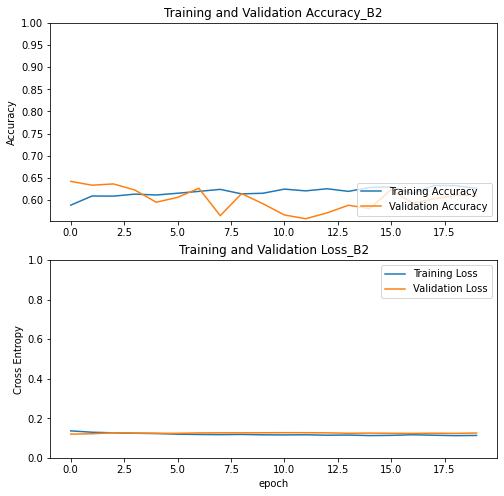

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_B2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_B2')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(x_val)
#y_pred_proba = model.predicted_proba(x_val)

In [ ]:
y_pred = np.argmax(predictions,axis =1)

y_val = np.argmax(y_val,axis =1)
print(y_val)
print(y_pred)

[1 1 0 ... 1 0 1]
[0 0 0 ... 0 0 0]


In [ ]:
mt = confusion_matrix(y_val, y_pred)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))


False positive rate : 13.148479 %
False negative rate : 85.120000 %


In [ ]:
import sklearn.metrics as metrics

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74      1118
           1       0.39      0.15      0.22       625

    accuracy                           0.61      1743
   macro avg       0.52      0.51      0.48      1743
weighted avg       0.55      0.61      0.55      1743



Accuracy: 61.04
Detail:
              precision    recall  f1-score   support

           0       0.65      0.87      0.74      1118
           1       0.39      0.15      0.22       625

    accuracy                           0.61      1743
   macro avg       0.52      0.51      0.48      1743
weighted avg       0.55      0.61      0.55      1743



'for i in range(len(classes)):\n    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  \n                           predictions[:,i])\n    ax[0].plot(fpr, tpr, lw=3, \n              label=\'{0} (area={1:0.2f})\'.format(classes[i], \n                              metrics.auc(fpr, tpr))\n               )\nax[0].plot([0,1], [0,1], color=\'green\', lw=3, linestyle=\'--\')\nax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], \n          xlabel=\'False Positive Rate\', \n          ylabel="True Positive Rate (Recall)", \n          title="Receiver operating characteristic")\nax[0].legend(loc="lower right")\nax[0].grid(True)\n    \n## Plot precision-recall curve\nfor i in range(len(classes)):\n    precision, recall, thresholds = metrics.precision_recall_curve(\n                 y_test_array[:,i], predictions[:,i])\n    ax[1].plot(recall, precision, lw=3, \n               label=\'{0} (area={1:0.2f})\'.format(classes[i], \n                                  metrics.auc(recall, precision))\n    

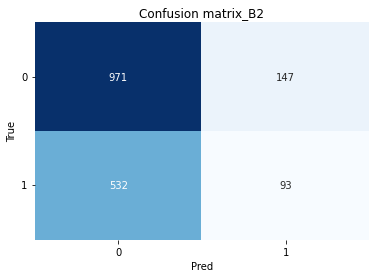

In [ ]:
import seaborn as sns## for processing

classes = np.unique(y_val)
y_test_array = pd.get_dummies(y_val, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_val, y_pred)
#auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy*100,2))
#print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_val, y_pred))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix_B2")
plt.yticks(rotation=0)
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

## Plot roc
"""for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                           predictions[:,i])
    ax[0].plot(fpr, tpr, lw=3,
              label='{0} (area={1:0.2f})'.format(classes[i],
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='green', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predictions[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
"""

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    mse = tf.keras.losses.MeanSquaredLogarithmicError()

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss= mse, metrics=["accuracy"]
    )


model1 = unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
#hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
hist = model.fit(x_train,y_train,
                  epochs= epochs,
                  #initial_epoch=hist.epoch[-1],
                  validation_data=(x_val, y_val))

Epoch 1/10
111/111 [==============================] - 41s 271ms/step - loss: 0.0927 - accuracy: 0.7043 - val_loss: 0.1459 - val_accuracy: 0.7665
Epoch 2/10
111/111 [==============================] - 28s 250ms/step - loss: 0.0919 - accuracy: 0.7111 - val_loss: 0.1477 - val_accuracy: 0.8003
Epoch 3/10
111/111 [==============================] - 28s 251ms/step - loss: 0.0915 - accuracy: 0.7173 - val_loss: 0.1534 - val_accuracy: 0.8514
Epoch 4/10
111/111 [==============================] - 28s 254ms/step - loss: 0.0893 - accuracy: 0.7241 - val_loss: 0.1497 - val_accuracy: 0.8210
Epoch 5/10
111/111 [==============================] - 28s 254ms/step - loss: 0.0858 - accuracy: 0.7357 - val_loss: 0.1497 - val_accuracy: 0.8227
Epoch 6/10
111/111 [==============================] - 28s 255ms/step - loss: 0.0856 - accuracy: 0.7436 - val_loss: 0.1522 - val_accuracy: 0.8210
Epoch 7/10
111/111 [==============================] - 28s 255ms/step - loss: 0.0827 - accuracy: 0.7478 - val_loss: 0.1582 - val_ac

In [ ]:
tf.keras.models.save_model(model1,"/content/drive/MyDrive/effnet3")

AttributeError: ignored

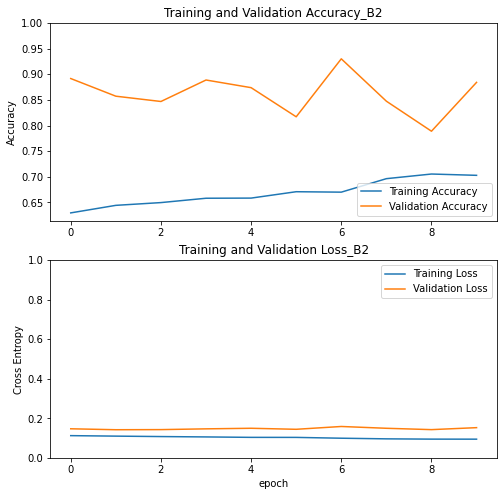

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_B2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_B2')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions1 = model.predict(x_val)
y_pred = np.argmax(predictions1, axis=1)

score = predictions1[0]
print(100 * score)


[77.696175   7.8084445]


In [ ]:
mt = confusion_matrix(y_val, y_pred)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

False positive rate : 10.554562 %
False negative rate : 86.560000 %


In [ ]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75      1118
           1       0.42      0.13      0.20       625

    accuracy                           0.62      1743
   macro avg       0.53      0.51      0.48      1743
weighted avg       0.57      0.62      0.56      1743



Accuracy: 0.62
Detail:
              precision    recall  f1-score   support

           0       0.65      0.89      0.75      1118
           1       0.42      0.13      0.20       625

    accuracy                           0.62      1743
   macro avg       0.53      0.51      0.48      1743
weighted avg       0.57      0.62      0.56      1743



'\nfig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))\n\n## Plot roc\nfor i in range(len(classes)):\n    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  \n                           predictions[:,i])\n    ax[0].plot(fpr, tpr, lw=3, \n              label=\'{0} (area={1:0.2f})\'.format(classes[i], \n                              metrics.auc(fpr, tpr))\n               )\nax[0].plot([0,1], [0,1], color=\'green\', lw=3, linestyle=\'--\')\nax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], \n          xlabel=\'False Positive Rate\', \n          ylabel="True Positive Rate (Recall)", \n          title="Receiver operating characteristic")\nax[0].legend(loc="lower right")\nax[0].grid(True)\n    \n## Plot precision-recall curve\nfor i in range(len(classes)):\n    precision, recall, thresholds = metrics.precision_recall_curve(\n                 y_test_array[:,i], predictions[:,i])\n    ax[1].plot(recall, precision, lw=3, \n               label=\'{0} (area={1:0.2f})\'.format(classes[i],

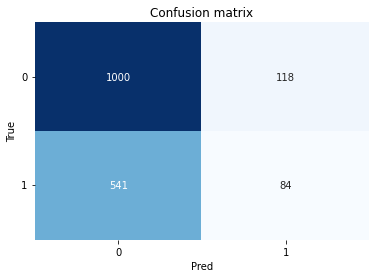

In [ ]:
import seaborn as sns## for processing

classes = np.unique(y_val)
y_test_array = pd.get_dummies(y_val, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_val, y_pred)
#auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
#print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_val, y_pred))

## Plot confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
"""
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                           predictions[:,i])
    ax[0].plot(fpr, tpr, lw=3,
              label='{0} (area={1:0.2f})'.format(classes[i],
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='green', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predictions[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()"""

In [ ]:
histt1 = model.evaluate(x_train,y_train)

111/111 [==============================] - 41s 337ms/step - loss: 0.0923 - accuracy: 0.7116


In [ ]:
histt2 = model.evaluate(x_val,y_val)

55/55 [==============================] - 18s 334ms/step - loss: 0.1525 - accuracy: 0.8841
